<center><b>Local Search - GSAT</b></center><br>
Finding solution to the SAT (Boolean Satisfiability Problem or Propositional Satisfiability Problem) using Local Search.

The code below reads in a "problem" file which contains a set of clauses connected by 'AND' logic gates. Each clause can have multiple variables, they are connected by 'OR' logic gates.
After that, it will attempt to find value for each variable by changing only 1 variable in each Step in a hope that it will satisfy all clauses.
The issue with Local Search is that in can get stuck in 'Local Optima' to get around this the system will try multiple restarts each with random initial solutions.

In [1]:
# Imports
import numpy as np
import random
import copy
import os
import matplotlib.pyplot as plt
from sympy import *
from sympy.plotting import plot, plot_parametric

%matplotlib inline

In [2]:
class SatProblemSolver():
    """
    SAT problem solver using Local Search
    On init a problem file is loaded in and the clauses are read.
    Call SolveSATProblem to solve the problem 
    """
    def __init__(self, problemFilename):
        self.variableLinks = {}
        self.loadProblemData(problemFilename)
        
        self.TotalCosts = []
        self.SolvedInNumSteps = 0
        self.SolvedInNumTries = 0
        
    def loadProblemData(self, problemFilename):
        """
        Loads in the problem file. It requires the file to be setup
        in a very specific way. The file should contain:
        - number of variables used
        - clauses
        """
        file = open(problemFilename, 'r')
        if file == None:
            print('ERROR - File not found: {}'.format(problemFilename))
            return
        
        self.numberOfVars = 0
        self.numberOfClauses = 0
        self.clauses = None
        # clauseTracker keeps track of each variable and of which clauses
        # they would affect. This helps speed up the cost calculations
        self.clausesTracker = None
        
        foundProblemLine = False
        clauseIndex = 0
        for line in file:
            words = line.split()
            if not foundProblemLine:
                if words[0] == 'p':
                    self.numberOfVars = int(words[2])
                    self.numberOfClauses = int(words[3])
                    self.clauses = [None] * self.numberOfClauses
                    self.clausesTracker = [False] * self.numberOfClauses
                    foundProblemLine = True
                    print('Found problem with {} variables and {} clauses'.format(self.numberOfVars, self.numberOfClauses))
            elif words[0] == '%':
                break
            else:
                words = [int(i) for i in words] # convert from string to int
                self.clauses[clauseIndex] = words[:-1]
                clauseIndex += 1
                
                # add tracking for each variable to see which clause it will affect
                for w in words:
                    if self.variableLinks.get(w, False) == False:
                        self.variableLinks[w] = []
                        
                    self.variableLinks[w].append(clauseIndex)
        
        pass
    
    def GetCharForInt(self, v):
        """
        Turns an int into an alphabet. An int that is larger than 26
        will still be turned into a letter in the alphabet but gets an
        index number e.g.: 'c2'
        """
        letter = v % 26
        index = int(v / 26)
        if index > 0:
            return (chr(letter + 97) + str(index))
        else:
            return chr(letter + 97)
        pass
    
    def PrintProblem(self):
        """
        Prints the SAT problem clauses in a CPP style formatting
        """
        line = ""
        for i in range(self.numberOfClauses):
            line += '('
            clause = self.clauses[i]
            for c in range(len(clause)):
                var = clause[c]
                varIndex = abs(var)-1 # -1 because array starts from 0
                varBool = var > 0
                if varBool == False:
                    line += '!'
                line += self.GetCharForInt(varIndex)
                if c < len(clause)-1:
                    line += ' || '
            line += ')'
            if i < self.numberOfClauses-1:
                line += ' && '
        print(line)
    
    def GetCostOfVarFlip(self, F, flippedIndex):
        """
        Calculates how would flipping a variable would affect the cost
        """
        addedCost = 0
        affectedClauses = self.variableLinks[flippedIndex]
        for caluseIndex in affectedClauses:
            clause = self.clauses[caluseIndex-1] # -1 because array starts from 0
            solved = False
            c = 0
            while(not solved and c < len(clause)):
                var = clause[c]
                varIndex = abs(var)-1 # -1 because array starts from 0
                varBool = var > 0
                # flip our variable and check the clause that way
                if varIndex == flippedIndex:
                    varBool = not varBool
                
                if F[varIndex] == varBool:
                    solved = True
                c += 1
            #if previously it was solved
            if self.clausesTracker[caluseIndex-1]: # -1 because array starts from 0
                #if now it's not solved anymore
                if not solved:
                    addedCost += 1
            #if previously it was NOT solved
            else:
                #if now it's solved
                if solved:
                    addedCost -= 1
                    
        return addedCost
        
    
    def CalculateInitialCost(self, F):
        """
        Calculates the fintess of the passed in solution
        """
        fitness = 0
        for i in range(self.numberOfClauses):
            clause = self.clauses[i]
            c = 0
            solved = False
            while(not solved and c < len(clause)):
                var = clause[c]
                varIndex = abs(var)-1 # -1 because array starts from 0
                varBool = var > 0
                if F[varIndex] == varBool:
                    solved = True
                c += 1
            if solved == False:
                self.clausesTracker[i] = False
                fitness += 1
            else:
                self.clausesTracker[i] = True
        return fitness
    
    def CreateInitialSolution(self):
        """
        Randomly assigns True or False to the solution variables
        """
        F = [False] * self.numberOfVars
        for i in range(self.numberOfVars):
            if random.random() < 0.5:
                F[i] = True
                
        return F
    
    def SolveSATProblem(self, maxTries, maxSteps):
        """
        Tries to solve the SAT problem. It can stuck in local optima that is why restarts are required
        maxTries - is the maximum number of times the algorithm will restart
        maxSteps - the maximum number of times the algorithm will try to improve its current solution
        """
        F = None
        
        self.TotalCosts = [] # used for graph
        
        for t in range(maxTries):
            F = self.CreateInitialSolution()
            currentCost = self.CalculateInitialCost(F)
            #print('{} Created initial solution with cost: {}'.format(t, currentCost))
            self.TotalCosts.append(currentCost)
            if currentCost == 0:
                self.SolvedInNumTries = t
                self.SolvedInNumSteps = s
                print('Initial solution solved in try {}, step: {}'.format(t, s))
                return F
            
            for s in range(maxSteps):
                # go through each variable and flip it, check how it would affect the score 
                variableScores = np.zeros(self.numberOfVars, dtype=int)
                for v in range(self.numberOfVars):
                    # 0 means no change - values would decrease cost, + values would increase cost
                    costOfFlipping = self.GetCostOfVarFlip(F, v)
                    variableScores[v] = costOfFlipping
                
                # when all variable changes have their cost value lets find the best
                varIndexOrders = np.argsort(variableScores)
                bestVarIndex = varIndexOrders[0]
                bestVarValue = variableScores[bestVarIndex]
                
                # how many best scores we have if there are multipl, pick one randomly
                numTies = np.count_nonzero(variableScores == bestVarValue)
                bestVarIndex = random.randrange(0, numTies)
                
                self.TotalCosts.append(currentCost + bestVarValue)
                
                if (currentCost + bestVarValue) < currentCost:
                    F[bestVarIndex] = not F[bestVarIndex]
                    currentCost += bestVarValue
                    
                    if currentCost == 0:
                        self.SolvedInNumTries = t
                        self.SolvedInNumSteps = s
                        print('Solved in try {}, step: {}'.format(t, s))
                        return F
                    
                else:
                    #print('{} Early out in step {}'.format(t,s))
                    # if we can't find a better solution, just early out and restart
                    break
                    
        return None


In [3]:
maxTries = 50 # number of times the algorithm will reset and try again if needed
maxSteps = 50 # number of times each try will try to improve the solution

path = 'data/SATdata/Inst/'
problemFiles = os.listdir(path)

Solving first SAT problem(uf20-01.cnf) with maxTries: 50 and maxSteps: 50
Found problem with 20 variables and 91 clauses
SAT problem to solve:
(d || !r || s) && (c || r || !e) && (!e || !h || !o) && (!t || g || !p) && (j || !m || !g) && (!l || !i || q) && (q || s || e) && (!p || i || o) && (k || !e || !n) && (r || !j || m) && (!c || k || l) && (!f || !q || !h) && (!r || n || a) && (!s || !o || j) && (l || r || !s) && (!h || d || g) && (!h || !i || d) && (g || q || !o) && (l || !g || !n) && (!j || !k || h) && (b || !o || !k) && (i || f || a) && (!k || t || !q) && (i || !o || m) && (l || !g || !q) && (!r || !b || t) && (t || l || d) && (s || k || n) && (!p || r || !d) && (!a || !q || !s) && (!m || o || j) && (!l || !n || !m) && (l || !n || !g) && (!g || p || j) && (f || j || g) && (t || n || !p) && (!s || q || k) && (!g || a || !t) && (!e || l || o) && (!d || !i || !m) && (l || !k || !g) && (!e || s || !h) && (a || p || q) && (t || !n || !o) && (m || !d || j) && (n || g || j) && (!e || i

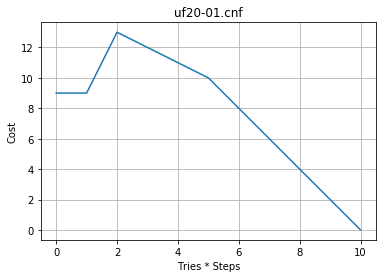

In [4]:
# Solving the first problem with extra details

problemFile  = path + problemFiles[0]
print('Solving first SAT problem({}) with maxTries: {} and maxSteps: {}'.format(problemFiles[0], maxTries, maxSteps))
solver = SatProblemSolver(problemFile)
print('SAT problem to solve:')
solver.PrintProblem()
solution = solver.SolveSATProblem(maxTries, maxSteps)

print('SAT solution is:')
if solution != None:
    for v in range(solver.numberOfVars):
        print('{} = {}'.format(solver.GetCharForInt(v), solution[v]))
else:
    print('Could NOT solve problem')
    
fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title(problemFiles[0])
axes.set_ylabel('Cost')
axes.set_xlabel('Tries * Steps')
axes.grid()
axes.plot(solver.TotalCosts)


Trying to solve problem: uf20-01.cnf in maxTries: 50, maxSteps: 50
Found problem with 20 variables and 91 clauses
Solved in try 0, step: 6
Solution is: [False, False, True, False, True, True, True, False, False, False, True, True, False, False, False, True, False, True, True, False]

Trying to solve problem: uf20-02.cnf in maxTries: 50, maxSteps: 50
Found problem with 20 variables and 91 clauses
Solved in try 3, step: 7
Solution is: [True, True, True, True, True, True, True, False, True, True, True, True, False, False, True, False, False, True, False, True]

Trying to solve problem: uf20-03.cnf in maxTries: 50, maxSteps: 50
Found problem with 20 variables and 91 clauses
Solved in try 1, step: 9
Solution is: [False, False, False, True, True, False, True, True, False, False, True, False, True, True, True, False, True, False, False, True]

Trying to solve problem: uf20-04.cnf in maxTries: 50, maxSteps: 50
Found problem with 20 variables and 91 clauses
Solved in try 0, step: 4
Solution is:

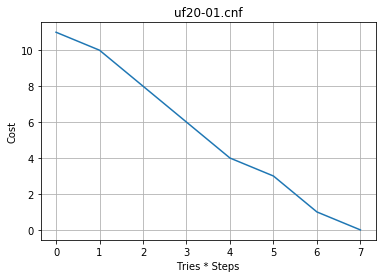

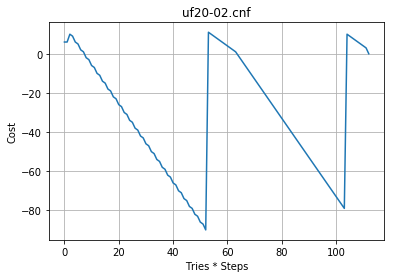

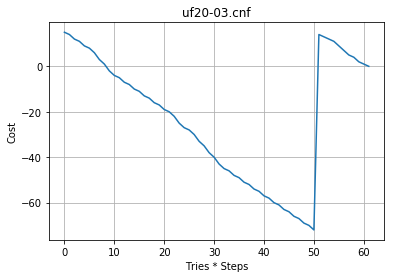

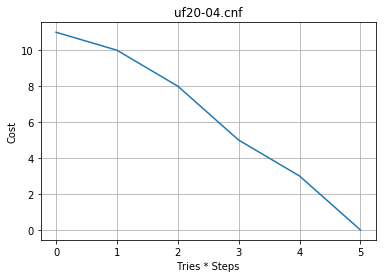

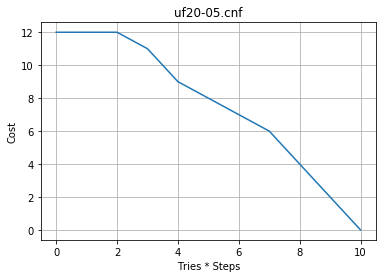

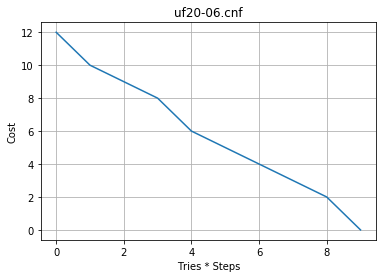

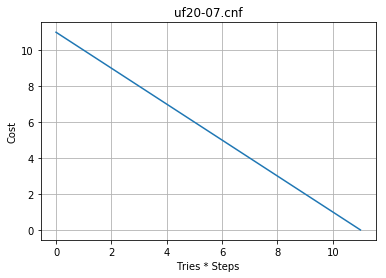

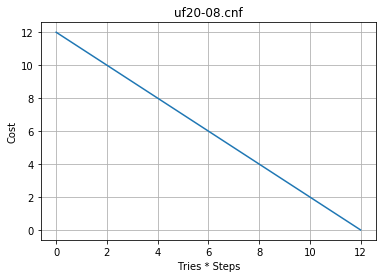

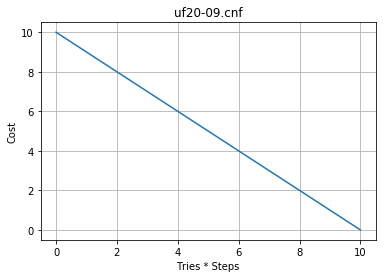

In [5]:
# Solving all SAT problems

solvedProblemsCounter = 0
solvedInTriesAverage = 0
solvedInStepsAverage = 0
for problem in problemFiles:
    problemFile  = path + problem

    print('Trying to solve problem: {} in maxTries: {}, maxSteps: {}'.format(problem, maxTries, maxSteps))
    solver = SatProblemSolver(problemFile)
    solution = solver.SolveSATProblem(maxTries, maxSteps)
    if solution != None:
        solvedProblemsCounter += 1
        solvedInTriesAverage += solver.SolvedInNumTries
        solvedInStepsAverage += solver.SolvedInNumSteps
    
    print('Solution is: {}'.format(solution))
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title(problem)
    axes.set_ylabel('Cost')
    axes.set_xlabel('Tries * Steps')
    axes.grid()
    axes.plot(solver.TotalCosts)
    print('')
    
print('Solved {} out of {}'.format(solvedProblemsCounter, len(problemFiles)))
solvedInTriesAverage = solvedInTriesAverage / solvedProblemsCounter
solvedInStepsAverage = solvedInStepsAverage / solvedProblemsCounter
print('On Average solved in {} tries and {} steps'.format(round(solvedInTriesAverage,2), round(solvedInStepsAverage,2)))
